# Computer vision - Laboratory

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

## 3.1 Background substraction methods


Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, remove all the "artifacts" considered as foreground related to movement extracting the background images.

Note: One of the applications of these methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras.

Read and visualize the sequence of images "images/Barcelona-sequence"
Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

<IPython.core.display.Javascript object>


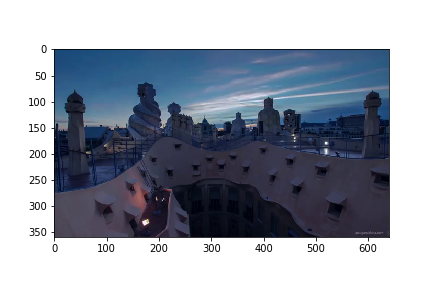

In [2]:
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt

ic = io.ImageCollection('images/Barcelona-sequence/*.png')
        # Reading a sequence of images from a folder

import matplotlib.animation as animation
%matplotlib nbagg 
    #Changing the pluggin is necessary always when visualizing a video!

i=0       #Inicializing the video display
fig = plt.figure()  # Create figure
im = plt.imshow(ic[i], animated=True) #Visualize the first image

def updatefig1(i):   #Updating the frame visualization
    im.set_array(ic[i*5]) #Changing the content of the canvas
    return im, #to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat= False)

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. Which measure can be used in order to visually distinguish the shots in a plot? Explain your solution.

Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">

**Hint:** take the following example of video and temporal plot visualization as a template. The plot must be replaced by a frame by frame measure to be defined by you, being applicable to distinguish the shots.

- If you need to convert the image to float, the command is: img_as_float()
- If you need the histogram, it is in skimage.exposure

In [ ]:
ic_gray = [skimage.color.rgb2gray(frame) for frame in ic]

histoarray = [np.histogram(frame) for frame in ic_gray]

In [ ]:
means = []
stds = []

for i in range(len(histoarray)):
    curr = histoarray[i]
    means.append(np.mean(curr[0]))
    stds.append(np.std(curr[0]))

In [ ]:
cosas = []

# We add to our histogram array the values letting them between 0 and 1
for i in range(len(histoarray)):
    y = means[i] + stds[i]
    cosas.append(y/10000)

In [ ]:
# Example
# Sinusoidal plot points generation
def data_gen():
    t = data_gen.t
    cnt = 0
    
    while cnt < len(ic):
        cnt+=1
        t += 0.05
        y = abs(cosas[cnt]-cosas[cnt-1])
        # adapted the data generator to yield both sin and cos
        yield t, y

data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 2)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10, repeat=False)
plt.show()

In [ ]:
# We crete a function that displays 2 images with their respective titles
def print_1x2(imatge,imatge_despres):
    fig, axarr = plt.subplots(1,2)
    fig.set_size_inches(25,10)
    
    #imatge
    axarr[0].imshow(imatge,cmap='gray')
    axarr[0].set_title('Inici de seqüència')
    axarr[0].xaxis.set_visible(False)
    axarr[0].yaxis.set_visible(False)
    
    #imatge després
    axarr[1].imshow(imatge_despres, cmap='gray')
    axarr[1].set_title('Final de seqüència')
    axarr[1].xaxis.set_visible(False)
    axarr[1].yaxis.set_visible(False)
    plt.show()

%matplotlib inline

hard_jump = []
thr = 0.71

last_idx = 0

# We check where the sequences end defining a threshold 'thr' defined by our graph
for i in range(1,len(cosas)):
    if(abs(cosas[i-1]-cosas[i]) >= thr):
        print_1x2(ic[last_idx],ic[i-1])
        hard_jump.append((last_idx,i))
        last_idx = i+1

# We must check if there is a sequence between the last_idx found and the last image

if(last_idx != len(ic)):    
    print_1x2(ic[last_idx], ic[-1])
    hard_jump.append((last_idx, len(ic)))

## 3.2 Background substraction

Apply the background substraction algorithm (check theory material).

Visualize, for each shot of the video:
    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

In [ ]:
from skimage import img_as_float

def print_1x1(imatge,title):
    fig, axarr = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    
    #image
    axarr.imshow(imatge,cmap='gray')
    axarr.set_title(title)
    axarr.xaxis.set_visible(False)
    axarr.yaxis.set_visible(False)

    plt.show()

def find_background(start,end):
    
    # We define an image with the same shape as the original ones just to fill it later
    background_image = np.zeros([ic[0].shape[0],ic[0].shape[1], ic[0].shape[2]], np.uint8)
    
    # We substract the sequence we want to extract the background
    sequence = ic[start:end]
    
    # We need
    red_channel_arr = []
    green_channel_arr = []
    blue_channel_arr = []
    
    for img in sequence:
        red_channel_arr.append(img_as_float(img[:,:,0]))
        green_channel_arr.append(img_as_float(img[:,:,1]))
        blue_channel_arr.append(img_as_float(img[:,:,2]))
        
    #we calculate the median for every channel, using every image in shot_images
    red_channel_median = np.median(red_channel_arr, axis = 0)       
    green_channel_median = np.median(green_channel_arr, axis = 0)       
    blue_channel_median = np.median(blue_channel_arr, axis = 0)       
    
    for i in range(sequence[0].shape[0]):
        for j in range(sequence[0].shape[1]):
            background_image[i,j] = [red_channel_median[i,j]*255,green_channel_median[i,j]*255,blue_channel_median[i,j]*255]

    return background_image

idx = 1
for pair in hard_jump:
    print_1x1(find_background(pair[0],pair[1]), "Background sequence "+str(idx))
    idx+=1

Comment your implementation including details. What happens if the shots are not correctly extracted? What happens if you find too many shots in the video? What do the static background images represent? In which situations does the algorithm work and in which it does not? What happens if you substract the background image from the original one?

Do you see any additional application for this algorithm?

**[OPTIONAL]**
Apply the algorithm to some other static video that you found.

The implementation is commented inside itself.

If the shots are not correctly extracted, the background image will be computed along the out-shot images which will end up being worse than the correct one (depending on how many out-shot images from all of them we take).



In [ ]:
from skimage.filters import threshold_mean
from skimage import img_as_float

%matplotlib inline

def print_1x1(imatge,title):
    fig, axarr = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    
    #imatge
    axarr.imshow(imatge,cmap='gray')
    axarr.set_title(title)
    axarr.xaxis.set_visible(False)
    axarr.yaxis.set_visible(False)

    plt.show()


extraction = ic[0] - threshold_mean(find_background(hard_jump[0][0],hard_jump[0][1]))
print_1x1((extraction*255).astype('uint8'), "Background extraction")

## 3.3 Clustering methods on the RGB-XY space

a) Read any image from the folder 'images' and segment it using Felzenszwalbs's method. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Which are the optimal values? Comment what algorithm is the method based in up to 3 lines most.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)
- Add title to the figures to explain what is displayed.

In [3]:
%matplotlib inline
from skimage.segmentation import felzenszwalb

loro = io.imread('images/loro.png')
segmentation_image = loro.copy()
segmentation_image1 = loro.copy()
segmentation_image2 = loro.copy()

segmentation_image = felzenszwalb(segmentation_image, scale = 100, sigma = 2, min_size = 50)
segmentation_image1 = felzenszwalb(segmentation_image1, scale = 50, sigma = 1, min_size = 25)
segmentation_image2 = felzenszwalb(segmentation_image2, scale = 150, sigma = 3, min_size = 75)

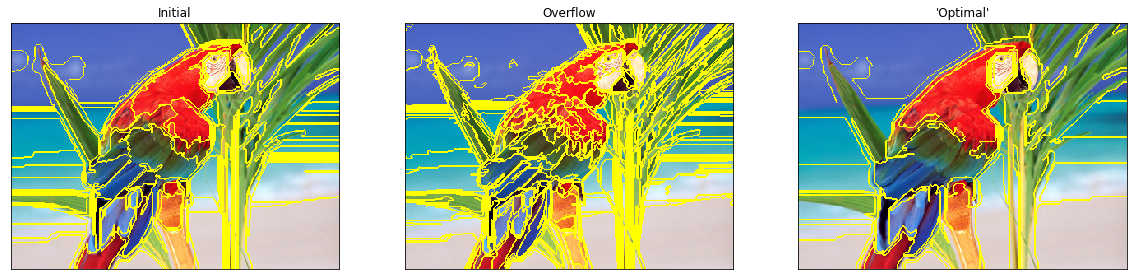

In [4]:
def print_1x3(imatge,imatge1, imatge2, title, title1, title2):
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(20,10)
    
    #imatge
    axarr[0].imshow(imatge,cmap='gray')
    axarr[0].set_title(title)
    axarr[0].xaxis.set_visible(False)
    axarr[0].yaxis.set_visible(False)
    
    axarr[1].imshow(imatge1, cmap='gray')
    axarr[1].set_title(title1)
    axarr[1].xaxis.set_visible(False)
    axarr[1].yaxis.set_visible(False)
    
    axarr[2].imshow(imatge2, cmap='gray')
    axarr[2].set_title(title2)
    axarr[2].xaxis.set_visible(False)
    axarr[2].yaxis.set_visible(False)
    plt.show()
print_1x3(skimage.segmentation.mark_boundaries(loro, segmentation_image),
         skimage.segmentation.mark_boundaries(loro, segmentation_image1),
         skimage.segmentation.mark_boundaries(loro, segmentation_image2),
         "Initial", "Overflow", "'Optimal'")

In [5]:
scale: modifying this value, we can control the number of produced segments and their size. As higher this value is, 
the clusters will be larger.

sigma: modifying this value, we can change the width of the Gaussian kernel. As higher this value is, the clusters will 
be larger, as the image will be smoother.

min_size: this value changes the minimum component size. Modifiying this will make clusters larger as we increase this value.
    
We consider that the optimal values are the ones at the third image, but this is our opinion. The 'Optimal' clusters represent 
each part of the colors from the bird. So we are focusing on the segmentation of the image looking for the different colors of 
the image.

The Felzenszwalb algorithm is a graph based segmentation algorithm. It measures the evidence for a boundary between two 
regions. It uses greedy solutions, but still the result is good enough to segmentate an image.

SyntaxError: invalid syntax (<ipython-input-5-b14d80525950>, line 1)

b) Segment the previous image using SLIC algorithm. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Upt o your opinion, which are the optimal values? Comment what algorithm is the method based in up to 3 lines.

In [6]:
%matplotlib inline
from skimage.segmentation import slic

loro = io.imread('images/loro.png')
segmentation_slic = loro.copy()
segmentation_slic1 = loro.copy()
segmentation_slic2 = loro.copy()

segmentation_slic = slic(segmentation_slic, n_segments=100, compactness=10.0, sigma=0)
segmentation_slic1 = slic(segmentation_slic1, n_segments=200, compactness=5.0, sigma=5)
segmentation_slic2 = slic(segmentation_slic2, n_segments=50, compactness=10.0, sigma=2.5)

D:\Programas\Anaconda\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
D:\Programas\Anaconda\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
D:\Programas\Anaconda\lib\site-packages\skimage\segmentation\slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the

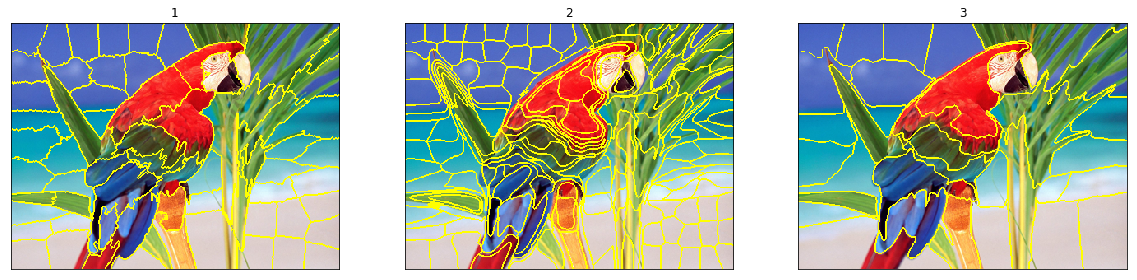

In [7]:
print_1x3(skimage.segmentation.mark_boundaries(loro, segmentation_slic),
         skimage.segmentation.mark_boundaries(loro, segmentation_slic1),
         skimage.segmentation.mark_boundaries(loro, segmentation_slic2),
         "1", "2", "3")

In [8]:
n_segments: modifying this value the result will have more or less segments. The value is the actual number of segments.

sigma: modifying this value, we can change the width of the Gaussian kernel. As higher this value is, the clusters will be 
larger, as the image will be smoother.

compactness: this value balances color proximity and space proximity. Higher values give more weight to space proximity.
    
    
As we did with the felzenszwalb exercice, consider that the optimal values are the ones at the third image, but this 
is our opinion. The 'Optimal' clusters represent each part of the colors from the bird.

SLIC algorithm, is based on k-means clustering in Color-(x,y,z) space. This technique is also known as superpixels, 
as the result of this algorithm is like the representation of a pixel for each segment.

SyntaxError: invalid syntax (<ipython-input-8-2e9472b1adb9>, line 1)

c) Plot the original image and the results of both algorithms in a 1x3 subplot. Calculate also the number of segments obtained on the image by each of the algorithms. Comment the differences between each method as well as their advantages and disadvantages.

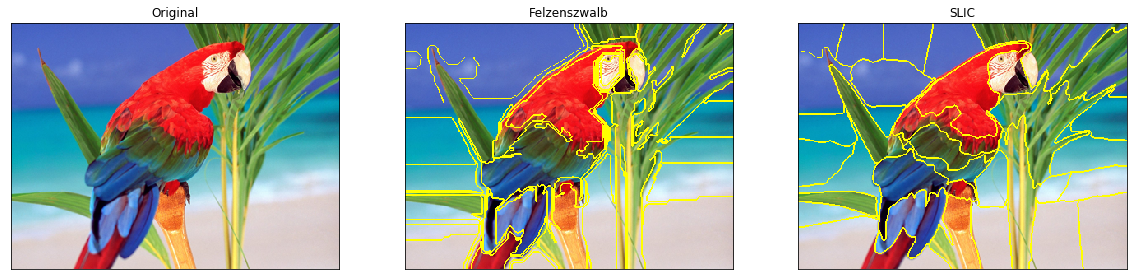

In [9]:

print_1x3(loro,
         skimage.segmentation.mark_boundaries(loro, segmentation_image2),
         skimage.segmentation.mark_boundaries(loro, segmentation_slic2),
         "Original", "Felzenszwalb", "SLIC")

In [10]:
The number of segments obtained in the SLIC image is equal as the n_segments we use, in this case its value is 50. 
For the Felzenszwalb image, we dont know how to calculate the number of segments. We can see that the result between the 
two images is a bit different. The Felzenszwalb image follows more the contours of the images, and the slic image separates 
the image into diferent "superpixels", following the contours. The felzenszwalb is better separating the image with the contours 
of an element in the image, for example, separating the parrot from the sea. The SLIC is better separating the image colors, 
without separating the image elements.

SyntaxError: invalid syntax (<ipython-input-10-0ca8f4bf84ef>, line 1)